In [1]:
import os
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

## Prepraration

In [2]:
FILES = {
    "tariff-distances-2022-01.csv": "https://opendata.rijdendetreinen.nl/public/tariff-distances/tariff-distances-2022-01.csv",
    "stations-2023-09.csv": "https://opendata.rijdendetreinen.nl/public/stations/stations-2023-09.csv",
}

FILES.update(
    {
        f"disruptions-{i}.csv": f"https://opendata.rijdendetreinen.nl/public/disruptions/disruptions-{i}.csv"
        for i in range(2013, 2024)
    }
)
FILES.update(
    {
        f"services-{i}.csv": f"https://opendata.rijdendetreinen.nl/public/services/services-{i}.csv.gz"
        for i in range(2019, 2025)
    }
)

In [3]:
current_files = os.listdir("data_hw")
for file in FILES:
    if file not in current_files:
        downloaded = FILES[file].split("/")[-1]
        os.system(f"wget {FILES[file]} -O data_hw/{downloaded}")
        if downloaded.endswith(".gz"):
            os.system(f"gzip -f -d data_hw/{downloaded}")

In [2]:
db = duckdb.connect("data_hw/duckdb_trains.db")
db

In [6]:
db.sql("""
CREATE TABLE IF NOT EXISTS stations AS
    FROM "data_hw/stations-2023-09.csv";
""")

In [7]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances AS
    FROM read_csv(
        "data_hw/tariff-distances-2022-01.csv",
        nullstr = 'XXX' 
    );
       
CREATE TABLE IF NOT EXISTS distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
""")

In [3]:
!docker compose up -d

[+] Running 0/1
 ⠋ Network lab2_default  Creating                                          0.0s 
[+] Running 1/2
 ✔ Network lab2_default       Created                                      0.0s 
 ⠋ Container lab2-postgres-1  Creating                                     0.1s 
[+] Running 1/2
 ✔ Network lab2_default       Created                                      0.0s 
 ⠙ Container lab2-postgres-1  Starting                                     0.2s 
[+] Running 1/2
 ✔ Network lab2_default       Created                                      0.0s 
 ⠹ Container lab2-postgres-1  Starting                                     0.3s 
[+] Running 1/2
 ✔ Network lab2_default       Created                                      0.0s 
 ⠸ Container lab2-postgres-1  Starting                                     0.4s 
[+] Running 1/2
 ✔ Network lab2_default       Created                                      0.0s 
 ⠼ Container lab2-postgres-1  Starting                                     0.5s 
[+] Running 2

In [4]:
db.sql("""INSTALL postgres; LOAD postgres;""")

conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

In [34]:
db.sql("""
       CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS  
       FROM 'data_hw/disruptions-*.csv';
       """)

db.sql(
    "SELECT YEAR(start_time) AS year FROM postgres_db.disruptions GROUP BY year ORDER BY year;"
)

┌───────┐
│ year  │
│ int64 │
├───────┤
│  2013 │
│  2014 │
│  2015 │
│  2016 │
│  2017 │
│  2018 │
│  2019 │
│  2020 │
│  2021 │
│  2022 │
│  2023 │
└───────┘

In [39]:
if os.listdir("data_hw").count("services.parquet") == 0:
    db.sql("""
    COPY (SELECT *
        FROM 'data_hw/services-*.csv')
    TO 'data_hw/services.parquet' (FORMAT 'PARQUET', CODEC 'ZSTD');
        """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [41]:
db.sql("""
       CREATE TABLE IF NOT EXISTS services AS  
       FROM 'data_hw/services.parquet';
       """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
db.sql("SELECT database, schema, name FROM (SHOW ALL TABLES)")

┌───────────────┬─────────┬────────────────┐
│   database    │ schema  │      name      │
│    varchar    │ varchar │    varchar     │
├───────────────┼─────────┼────────────────┤
│ duckdb_trains │ main    │ distances      │
│ duckdb_trains │ main    │ distances_long │
│ duckdb_trains │ main    │ services       │
│ duckdb_trains │ main    │ stations       │
│ postgres_db   │ public  │ disruptions    │
└───────────────┴─────────┴────────────────┘

## Queries section 7

1. How many trains departed from Amsterdam Central station overall?

In [55]:
db.sql("""
SELECT COUNT(DISTINCT "Service:RDT-ID") AS total_departures
FROM services
WHERE "Stop:Station name" = 'Amsterdam Centraal'
  AND COALESCE("Stop:Departure cancelled", FALSE) = FALSE
  AND "Stop:Departure time" IS NOT NULL;
""")

┌──────────────────┐
│ total_departures │
│      int64       │
├──────────────────┤
│          1544418 │
└──────────────────┘

2. Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay.

In [56]:
db.sql("""
SELECT "Service:Type" AS service_type, AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
  AND COALESCE("Stop:Arrival cancelled", FALSE) = FALSE
GROUP BY "Service:Type"
ORDER BY avg_arrival_delay DESC;
""")

┌────────────────────┬────────────────────┐
│    service_type    │ avg_arrival_delay  │
│      varchar       │       double       │
├────────────────────┼────────────────────┤
│ Alpen Express      │ 27.826625386996906 │
│ Krokus Express     │ 18.304347826086957 │
│ European Sleeper   │ 12.453668861712135 │
│ Nightjet           │   9.44079570965328 │
│ Eurostar           │  7.153300435413643 │
│ Thalys             │  5.707678662849808 │
│ ICE International  │  5.646820293370558 │
│ Nachttrein         │ 4.5620731217356365 │
│ Int. Trein         │ 4.3945368171021375 │
│ Stoomtrein         │ 3.6012658227848102 │
│     ·              │                 ·  │
│     ·              │                 ·  │
│     ·              │                 ·  │
│ Tram i.p.v. trein  │                0.0 │
│ Niet instappen     │                0.0 │
│ Belbus             │                0.0 │
│ Bus                │                0.0 │
│ Taxibus ipv trein  │                0.0 │
│ Tram ipv trein     │          

3. What was the most common disruption cause in different years? MODE function may be useful.

In [58]:
db.sql("""
SELECT 
    EXTRACT(YEAR FROM start_time)::INT AS year,
    MODE(cause_en),
  FROM postgres_db.disruptions
  GROUP BY year
""")

┌───────┬───────────────────┐
│ year  │ "mode"(cause_en)  │
│ int32 │      varchar      │
├───────┼───────────────────┤
│  2020 │ broken down train │
│  2016 │ broken down train │
│  2014 │ broken down train │
│  2018 │ broken down train │
│  2021 │ broken down train │
│  2013 │ points failure    │
│  2019 │ broken down train │
│  2017 │ broken down train │
│  2022 │ broken down train │
│  2015 │ broken down train │
│  2023 │ broken down train │
├───────┴───────────────────┤
│ 11 rows         2 columns │
└───────────────────────────┘

4. How many trains started their overall service in any Amsterdam station?

In [ ]:
db.sql("""
SELECT Count(company), number
    FROM
    (SELECT "Service:Company" company, "Service:Train number" AS number
    FROM services
    GROUP BY company, number)
GROUP BY number
ORDER BY Count(company) DESC;
""")

┌────────────────┬────────┐
│ count(company) │ number │
│     int64      │ int64  │
├────────────────┼────────┤
│             11 │ 982632 │
│             11 │ 982638 │
│             11 │ 982637 │
│             11 │ 982690 │
│             11 │ 982633 │
│             11 │ 982687 │
│             11 │ 982625 │
│             11 │ 982629 │
│             11 │ 981851 │
│             11 │ 982630 │
│              · │    ·   │
│              · │    ·   │
│              · │    ·   │
│              4 │ 988726 │
│              4 │ 988587 │
│              4 │ 980922 │
│              4 │ 981046 │
│              4 │ 981002 │
│              4 │ 981009 │
│              4 │ 981000 │
│              4 │ 980996 │
│              4 │ 981040 │
│              4 │ 980943 │
├────────────────┴────────┤
│ ? rows        2 columns │
└─────────────────────────┘

In [68]:
# As shown above, the train number can be assigned to multiple companies, and there is no information
# weather it's the same train or not. So I include company in the grouping.
db.sql("""
WITH first_ride AS (SELECT "Service:Company" AS company, 
       "Service:Train number" AS train_number, 
       MIN("Stop:Departure time") AS departure_time
FROM services
GROUP by company, train_number)

SELECT company, train_number, departure_time, "Stop:Station name"
FROM first_ride
INNER JOIN services ON first_ride.company = services."Service:Company"
       AND first_ride.train_number = services."Service:Train number"
       AND first_ride.departure_time = services."Stop:Departure time"
WHERE "Stop:Station name" LIKE 'Amsterdam Centraal'
ORDER BY train_number

""")

┌─────────┬──────────────┬─────────────────────┬────────────────────┐
│ company │ train_number │   departure_time    │ Stop:Station name  │
│ varchar │    int64     │      timestamp      │      varchar       │
├─────────┼──────────────┼─────────────────────┼────────────────────┤
│ NS      │          105 │ 2019-01-02 07:08:00 │ Amsterdam Centraal │
│ NS Int  │          105 │ 2021-03-06 07:08:00 │ Amsterdam Centraal │
│ NS      │          121 │ 2019-01-02 05:38:00 │ Amsterdam Centraal │
│ NS Int  │          121 │ 2021-03-06 05:38:00 │ Amsterdam Centraal │
│ NS Int  │          123 │ 2021-03-06 09:38:00 │ Amsterdam Centraal │
│ NS      │          123 │ 2019-01-01 09:38:00 │ Amsterdam Centraal │
│ NS      │          125 │ 2019-01-01 11:38:00 │ Amsterdam Centraal │
│ NS Int  │          125 │ 2021-03-06 11:38:00 │ Amsterdam Centraal │
│ NS Int  │          127 │ 2021-03-06 13:38:00 │ Amsterdam Centraal │
│ NS      │          127 │ 2019-01-01 13:38:00 │ Amsterdam Centraal │
│ ·       │         

5. What fraction of services was run to final destinations outside the Netherlands?

In [90]:
db.sql("""
WITH last_stop AS(
    SELECT "Service:RDT-ID", MAX("Stop:Arrival time") AS time
    FROM services
    GROUP BY "Service:RDT-ID"
    ),
       
all_services AS( 
    SELECT Count(DISTINCT "Service:RDT-ID") AS count
    FROM services
    ),
       
outsiders AS(
    SELECT services."Service:RDT-ID", "Stop:Station code", "Stop:Arrival time", stations.country
    FROM services
    JOIN last_stop ON services."Service:RDT-ID" = last_stop."Service:RDT-ID"
        AND services."Stop:Arrival time" = last_stop.time
    JOIN stations ON services."Stop:Station code" = stations.code
    WHERE stations.country <> 'NL'
)

SELECT (SELECT Count(DISTINCT "Service:RDT-ID") FROM outsiders)::FLOAT / (SELECT count FROM all_services) AS fraction_outside_nl;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┐
│ fraction_outside_nl │
│        float        │
├─────────────────────┤
│         0.036013305 │
└─────────────────────┘

6. What is the largest distance between stations in the Netherlands (code NL)?

In [98]:
db.sql("""
SELECT distance
FROM distances_long
JOIN stations AS s1 ON distances_long.station = s1.code
JOIN stations AS s2 ON distances_long.other_station = s2.code
WHERE s1.country = 'NL' AND s2.country = 'NL'
ORDER BY distance DESC
LIMIT 1;
""")

┌──────────┐
│ distance │
│  int64   │
├──────────┤
│      426 │
└──────────┘

7. Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.

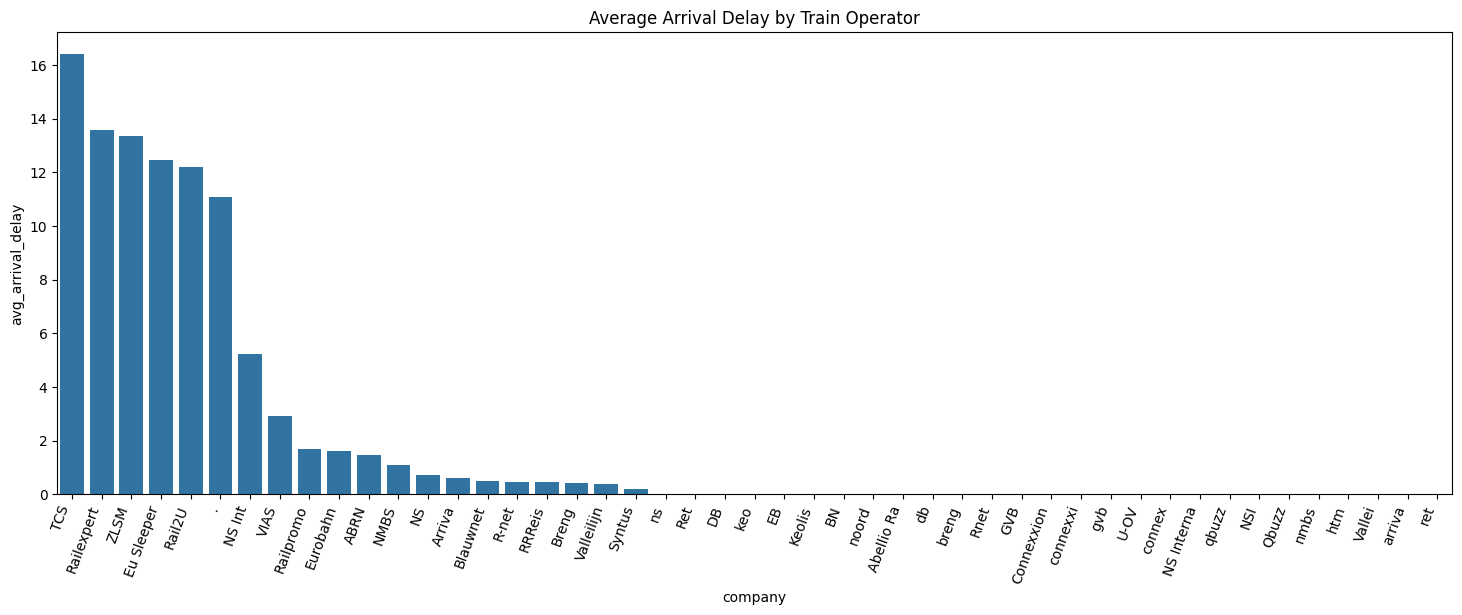

In [ ]:
arrival_delay = db.sql("""
SELECT "Service:Company" AS company, AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
  AND COALESCE("Stop:Arrival cancelled", FALSE) = FALSE
GROUP BY "Service:Company"
ORDER BY avg_arrival_delay DESC
""").df()


ax = sns.barplot(data=arrival_delay, x="company", y="avg_arrival_delay").set_title(
    "Average Arrival Delay by Train Operator"
)
fig = plt.gcf()
fig.set_size_inches(18, 6)
plt.xticks(rotation=70, ha="right")
plt.show()

8. How many services were disrupted in different years? Make a line plot.

Text(0.5, 1.0, 'Number of Disrupted Services per Year')

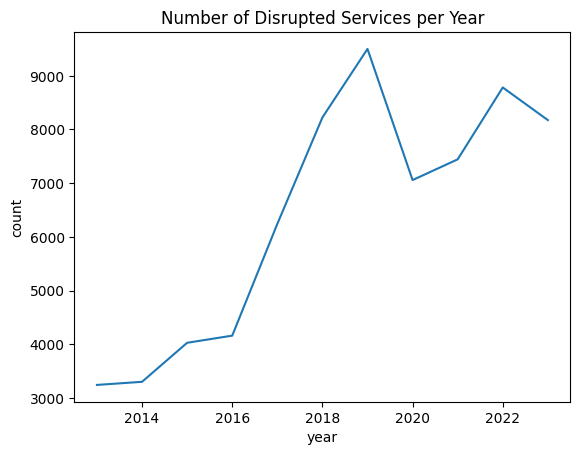

In [28]:
disrupted_services_per_year = db.sql("""
SELECT COUNT(TRIM(x)::INT) AS count,
    YEAR(start_time) AS year
    FROM postgres_db.disruptions,
    UNNEST(str_split(rdt_lines_id, ',')) AS t(x)
    GROUP BY year
""").df()
sns.lineplot(data=disrupted_services_per_year, x="year", y="count").set_title(
    "Number of Disrupted Services per Year"
)

9. What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.

Text(0.5, 1.0, 'Number of Completely Cancelled Services per Year')

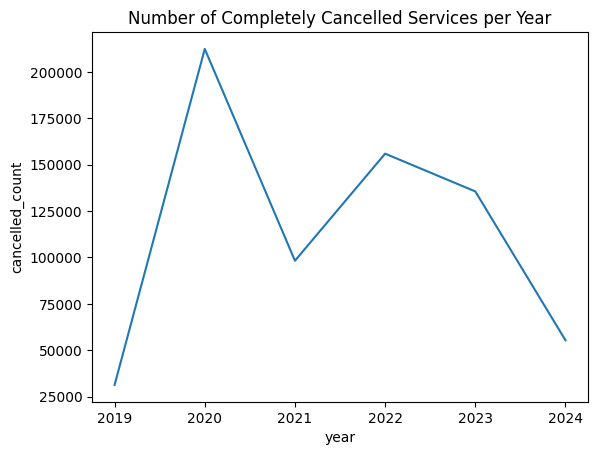

In [45]:
services_cancelled_per_year = db.sql("""
WITH cancelled_services AS (
    SELECT "Service:RDT-ID" AS service_id, 
        YEAR("Service:Date") AS year,
    FROM services
    WHERE COALESCE("Service:Completely cancelled", FALSE) = TRUE
    GROUP BY year, "Service:RDT-ID"
)
SELECT COUNT(DISTINCT service_id) AS cancelled_count, year
FROM cancelled_services
GROUP BY year
ORDER BY year;
       
""").df()

sns.lineplot(data=services_cancelled_per_year, x="year", y="cancelled_count").set_title(
    "Number of Completely Cancelled Services per Year"
)

(that's actually pretty intresting that we can see 2020 repercusions on public transit due to covid-19)

## Qureries section 8

This specific instruction was a bit unclear, but as a "start" and "end" I understand the first and the last stations that were on the route, not two adjacent

In [7]:
db.sql("""
CREATE TABLE IF NOT EXISTS station_connections AS
WITH ordered_stops AS (
SELECT
    "Service:RDT-ID" as service_rdt_id,
    "Stop:Station code" AS first_station_code,
    LEAD("Stop:Station code") OVER (
        PARTITION BY "Service:RDT-ID"
        ORDER BY "Stop:Departure time"
    ) AS next_station_code,
    "Stop:Departure time" AS departure_time
FROM services
WHERE "Stop:Departure time" IS NOT NULL
),
stops_with_distances AS (
    SELECT * FROM ordered_stops
    JOIN distances_long 
        ON ordered_stops.first_station_code = distances_long.Station
        AND ordered_stops.next_station_code = distances_long.other_station
    AND next_station_code IS NOT NULL
    ORDER BY ordered_stops.departure_time
)
SELECT service_rdt_id,
    FIRST(first_station_code ORDER BY departure_time ASC)  AS start_station_code,
    LAST(next_station_code ORDER BY departure_time ASC)    AS end_station_code,
    SUM(distance)
FROM stops_with_distances
GROUP BY service_rdt_id;

""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
db.sql("""
SELECT * FROM station_connections LIMIT 10;
""")

┌────────────────┬────────────────────┬──────────────────┬───────────────┐
│ service_rdt_id │ start_station_code │ end_station_code │ sum(distance) │
│     int64      │      varchar       │     varchar      │    int128     │
├────────────────┼────────────────────┼──────────────────┼───────────────┤
│        3822911 │ ASD                │ LEDN             │            48 │
│        3823014 │ GN                 │ HGZ              │            15 │
│        3822900 │ HVS                │ ASDM             │            25 │
│        3823053 │ GN                 │ LEDN             │           256 │
│        3823083 │ LW                 │ SKND             │            21 │
│        3823349 │ LW                 │ BP               │            24 │
│        3823477 │ DDR                │ ALMB             │           133 │
│        3823488 │ AMF                │ EDC              │            32 │
│        3823518 │ GN                 │ DZW              │            37 │
│        3823557 │ ED    

### just for debuging purposes we can check for few routes

In [9]:
db.sql("""
       
WITH ordered_stops AS (
SELECT
    "Service:RDT-ID" as service_rdt_id,
    "Stop:Station code" AS first_station_code,
    LEAD("Stop:Station code") OVER (
        PARTITION BY "Service:RDT-ID"
        ORDER BY "Stop:Departure time"
    ) AS next_station_code,
    "Stop:Departure time" AS departure_time
FROM services
WHERE "Stop:Departure time" IS NOT NULL
)
SELECT * FROM ordered_stops
JOIN distances_long 
    ON ordered_stops.first_station_code = distances_long.Station
    AND ordered_stops.next_station_code = distances_long.other_station
WHERE service_rdt_id = '3823014'
AND next_station_code IS NOT NULL
ORDER BY ordered_stops.departure_time;
""")

┌────────────────┬────────────────────┬───────────────────┬─────────────────────┬─────────┬───────────────┬──────────┐
│ service_rdt_id │ first_station_code │ next_station_code │   departure_time    │ Station │ other_station │ distance │
│     int64      │      varchar       │      varchar      │      timestamp      │ varchar │    varchar    │  int64   │
├────────────────┼────────────────────┼───────────────────┼─────────────────────┼─────────┼───────────────┼──────────┤
│        3823014 │ GN                 │ GERP              │ 2020-04-18 08:38:00 │ GN      │ GERP          │        2 │
│        3823014 │ GERP               │ KW                │ 2020-04-18 08:40:00 │ GERP    │ KW            │       10 │
│        3823014 │ KW                 │ MTH               │ 2020-04-18 08:48:00 │ KW      │ MTH           │        1 │
│        3823014 │ MTH                │ HGZ               │ 2020-04-18 08:51:00 │ MTH     │ HGZ           │        2 │
└────────────────┴────────────────────┴─────────

### max distance

In [16]:
db.sql("""
WITH max_distances AS (
    SELECT 
        MAX("sum(distance)") AS max_distance
    FROM station_connections
)
SELECT sc.*
FROM station_connections sc
JOIN max_distances md
    ON sc."sum(distance)" = md.max_distance;
""")

┌────────────────┬────────────────────┬──────────────────┬───────────────┐
│ service_rdt_id │ start_station_code │ end_station_code │ sum(distance) │
│     int64      │      varchar       │     varchar      │    int128     │
├────────────────┼────────────────────┼──────────────────┼───────────────┤
│       12609957 │ DZ                 │ GNN              │          2284 │
└────────────────┴────────────────────┴──────────────────┴───────────────┘

In [ ]:
distances_table = db.sql("""
SELECT * FROM station_connections
""").df()

[]

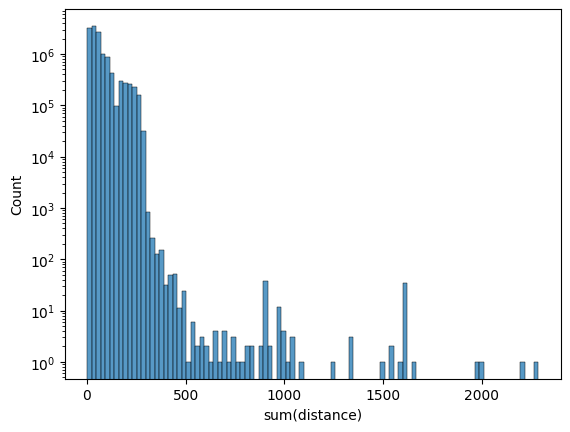

In [23]:
sns.histplot(distances_table["sum(distance)"], bins=100)
plt.semilogy()